# Likelihood nodal #

In [5]:
#Paquetes a cargar

import cobaya
import numpy as np
from scipy.special import erf
from scipy.interpolate import CubicSpline
import camb #Tengo que solucionar como importar CAMB por defecto
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Aquí se leen los datos del catálogo sintético.
# Routine to read the synthetic data.

# It should be stright-forward to read it with pandas but this is the literal tranlation of fortran code

# Define a class to read the data
def read_data(path_to_data):
    data = {}
    data['nk'] = 125
    data['nz'] = 7

    pk_filename = path_to_data+'FicticioHighZArrayEnK.dat'
    z_filename = path_to_data+'ZdataFicticioHighZ.dat'

    data['k'] = np.zeros(data['nk'])
    data['tk'] = np.zeros(data['nk'])
    data['pkz'] = np.zeros((data['nz'], data['nk']))
    data['Nxz'] = np.zeros((data['nz'], data['nk']))
    data['za'] = np.zeros(data['nz'])
    data['Dz'] = np.zeros(data['nz'])
    data['fz'] = np.zeros(data['nz'])
    data['Haz'] = np.zeros(data['nz'])
    data['ndz'] = np.zeros(data['nz'])
    data['deltaz'] = np.zeros(data['nz'])

    with open(pk_filename) as file:
        for i in range(data['nk']):
            line = file.readline().split()
            data['k'][i] = float(line[0])
            data['tk'][i] = float(line[1])
            data['pkz'][0][i] = float(line[2])
            data['pkz'][1][i] = float(line[3])
            data['pkz'][2][i] = float(line[4])
            data['pkz'][3][i] = float(line[5])
            data['pkz'][4][i] = float(line[6])
            data['pkz'][5][i] = float(line[7])
            data['pkz'][6][i] = float(line[8])
            data['Nxz'][0][i] = float(line[9])
            data['Nxz'][1][i] = float(line[10])
            data['Nxz'][2][i] = float(line[11])
            data['Nxz'][3][i] = float(line[12])
            data['Nxz'][4][i] = float(line[13])
            data['Nxz'][5][i] = float(line[14])
            data['Nxz'][6][i] = float(line[15])

    with open(z_filename) as file:
        for i in range(data['nz']):
            line = file.readline().split()
            data['za'][i] = float(line[0])
            data['Dz'][i] = float(line[1])
            data['fz'][i] = float(line[2])
            data['Haz'][i] = float(line[3])
            data['ndz'][i] = float(line[4])
            data['deltaz'][i] = float(line[5])

    return data

In [3]:
# Aquí se da el string del path para ejecutar read_data
# Read data as dictionary
data = read_data('/Users/guillermo/Desktop/Synthetic_Data/')
# show data, we do not need Dz, fz, Haz, these are requested by camb
data.keys()

dict_keys(['nk', 'nz', 'k', 'tk', 'pkz', 'Nxz', 'za', 'Dz', 'fz', 'Haz', 'ndz', 'deltaz'])

In [6]:
# Let's try to reproduce with simple CAMB the nodes, Fig 1 of the paper.

#Se dan los valores de los nodos

nodes_log_k = [-5, -3.3, -2.1, -1.8, -1.61]
nodes_log_PPS = [3.5, 3.7, 1, 3.6, 3]

#Se deshace la escala log
nodes_k = np.exp(nodes_log_k)
nodes_PPS =np.exp(nodes_log_PPS)*1e-10

# Let's compare to scipy
#Aquí se realiza algún tipo de interpolación
func = interp1d(nodes_k, nodes_PPS,
                axis=0,  # interpolate along columns
                bounds_error=False,
                kind='quadratic',
                fill_value=(nodes_PPS[0], nodes_PPS[-1]))

#Set up a new set of parameters for CAMB
#Metemos en pars los parámetros de CAMB, y en la subcategoría de InitPower esos datos. 
pars = camb.CAMBparams()
pars.InitPower = camb.initialpower.SplinedInitialPower()

#This function sets up with one massive neutrino and helium set using BBN consistency
#Aquí cambiamos los parámetros por defecto de CAMB por estos que nos interesan a nosotros
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)

#Aquí decimos que en esta subcategoría se incorporen los ks de los nodos con su interpolación
#pars.InitPower.set_scalar_table(nodes_k, nodes_PPS)
pars.InitPower.set_scalar_log_regular(data['k'][0], data['k'][-1], func(data['k']))

#Ahora damos los redshifts de nuestro catálogo con el kmax del mismo para el espectro de materia.
pars.set_matter_power(redshifts=data['za'], kmax=data['k'][-1])



Note: redshifts have been re-sorted (earliest first)


class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 0.45714471326890904
   k_per_logint = 0
   PK_num_redshifts = 7
   PK_redshifts = [2.9, 2.7, 2.5, 2.3, 2.1, 1.9, 1.7]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.022
 omch2 = 0.122
 omk = 0.0
 omnuh2 = 0.000644866570625114
 H0 = 67.5
 TCMB = 2.7255
 YHe = 0.24569492503497048
 num_nu_massless = 2.0293333333333337
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0146666666666666]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <SplinedInitialPower>
   effective_ns_for_nonl

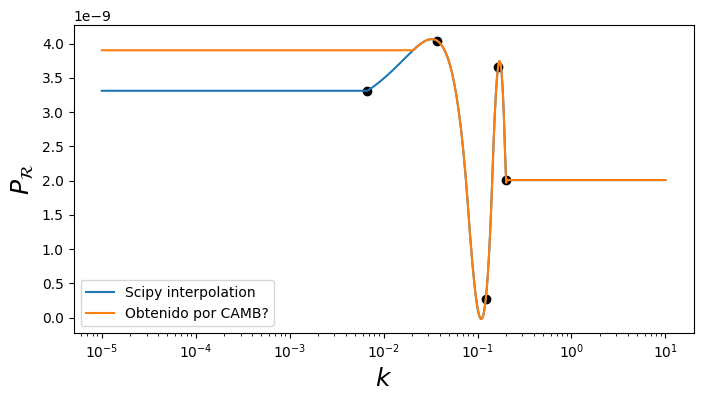

In [10]:
# get camb results 
# Obtenemos los resultados de CAMB y los comparamos a nuestros nodos interpolados

# Obtenemos los resultados de CAMB con todos los cambios que hemos hecho en 'pars':
results = camb.get_results(pars)

#Creamos los ejes x e y para representar. Array de ks, llamado 'k':
k = 10**np.linspace(-5, 1, 500)

#Valores del P(k) en ese array 'k':
scalar_pk = pars.scalar_power(k)

#Representamos el P(k):
plt.figure(figsize=(8,4))
plt.semilogx(k, func(k), label = "Scipy interpolation"); #Se pinta la interpolación
plt.semilogx(k, scalar_pk, label= "Obtenido por CAMB?"); #Se pinta lo obtenido por CAMB
plt.scatter(nodes_k, nodes_PPS, color='black', marker='o'); #Aquí se pintan los nodos
plt.ylabel(r'$P_\mathcal{R}$', fontsize=18)
plt.xlabel(r'$k$', fontsize=18);
#plt.xlim(1e-2, 0.1);
#plt.ylim(1e-11, 5e-9);
plt.legend();

In [11]:
from camb import model #Acaso así se llama a CAMB?

#Linear spectra
pars.NonLinear = model.NonLinear_none #Esto no sé para qué se hace
results = camb.get_results(pars) #Realmente esto está repetido

#Se da valor a estas variables desde el P materia(k) de CAMB, especificando nuestras escalas extremas y el número de puntos
#kh son las ks, pk el valor del Pmateria(k)
kh, z, pk = results.get_matter_power_spectrum(minkh=data['k'][0], maxkh=data['k'][-1], npoints = 200)

#Lo mismo con sigma8 para cada bin de z
s8 = np.array(results.get_sigma8())
print(z)

[1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9]


In [16]:
camb.get_results(pars).get_matter_power_spectrum(minkh=data['k'][0], maxkh=data['k'][-1], npoints = 20)

(array([0.020594  , 0.02424373, 0.02854026, 0.03359824, 0.03955261,
        0.04656222, 0.05481409, 0.06452839, 0.07596427, 0.08942686,
        0.10527531, 0.12393247, 0.1458961 , 0.17175218, 0.20219054,
        0.23802327, 0.28020636, 0.32986524, 0.3883248 , 0.45714471]),
 [1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9],
 array([[8.95354779e+03, 8.50874870e+03, 7.79396167e+03, 6.98343839e+03,
         6.13976818e+03, 5.34782386e+03, 4.71163327e+03, 4.11601763e+03,
         3.31094987e+03, 2.23231218e+03, 1.26748725e+03, 5.26617023e+02,
         7.02798351e+01, 1.28092351e+01, 2.59985279e+02, 5.13620783e+02,
         3.43227197e+02, 1.64836068e+02, 1.18895795e+02, 8.53107725e+01],
        [7.81858258e+03, 7.43032079e+03, 6.80626655e+03, 6.09857718e+03,
         5.36190553e+03, 4.67037343e+03, 4.11483739e+03, 3.59471303e+03,
         2.89164261e+03, 1.94962525e+03, 1.10698932e+03, 4.59936257e+02,
         6.13812725e+01, 1.11874281e+01, 2.27068691e+02, 4.48592914e+02,
         2.99772940e+02, 1.439

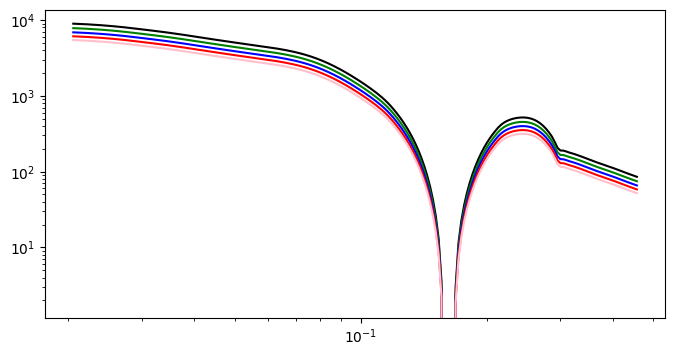

In [8]:
# Plot corresponding P_matter
plt.figure(figsize=(8,4))
for i, (redshift, color) in enumerate(zip(z,['black', 'green', 'blue', 'red', 'pink'])):
    plt.loglog(kh, pk[i,:], color=color, label='z={}'.format(redshift))
    #plt.ylabel(r'$P_m}$', fontsize=18),
    #plt.xlabel(r'$k$', fontsize=18)
    #plt.legend(loc='lower left', fontsize=18); #Especificaciones del Plot: labels y leyenda.


In [9]:
# I assume this method above is ok, so I will now create the classes to interface with Cobaya
# I will create a cobaya theory NodesInPrimordialPk and a cobaya external likelihood Pklike classes

#Se crean las clases para interactuar con Cobaya: NodesInPrimordialPk (teoría) y Pklike (likelihood)

from cobaya.theory import Theory
from cobaya.likelihood import Likelihood

In [10]:
#Clase con la teoría, es decir, con la modificación del Primordial para incluir nuestros nodos
class NodesInPrimordialPk(Theory):

    def initialize(self): #Creamos una función que devolverá self. Ahí metemos unos ks.
        # need to provide valid results at wide k range, any that might be used, please change accordantly
        self.ks = 10**np.linspace(-5, 1, 500)

    def calculate(self, state, want_derived=True, **params_values_dict): #Esta función hace....
        pivot_scalar = 0.05 #please change if you need
        #Ahora metemos en k1, pk1... los valores de los nodos anteriormente fijados
        nodes_k = [params_values_dict['k1'], params_values_dict['k2'], params_values_dict['k3'], params_values_dict['k4'], params_values_dict['k5']]
        nodes_PPS = [params_values_dict['pk1'], params_values_dict['pk2'], params_values_dict['pk3'], params_values_dict['pk4'], params_values_dict['pk5']]
        
        #Se interpolan estos nodos.
        Pk_func = interp1d(nodes_k, nodes_PPS,
                axis=0,  # interpolate along columns
                bounds_error=False,
                kind='quadratic',
                fill_value=(nodes_PPS[0], nodes_PPS[-1]))
        
        #Parece que aquí definimos la variable state, en la que construimos el P(k) en todas las escalas
        state['primordial_scalar_pk'] = {'kmin': self.ks[0], 'kmax': self.ks[-1],
                                         'Pk': Pk_func(self.ks), 'log_regular': True}

    #No entiendo para que sirven estas dos funciones:
    def get_primordial_scalar_pk(self):
        return self.current_state['primordial_scalar_pk']
   
    #Parece que aquí hay que indicar qué parámetros usamos
    def get_can_support_params(self):
        # Please, define here as many node params you like
        return ['k1', 'k2', 'k3', 'k4', 'k5', 'pk1', 'pk2', 'pk3', 'pk4', 'pk5']


In [107]:
     self.data = read_data('/Users/guillermo/Desktop/Synthetic_Data/')

NameError: name 'self' is not defined

In [11]:
#Clase con el likelihood. Aquí tendremos que introducir nuestro modelo y el cálculo del likelihood

class Pklike(Likelihood): #Se define la clase.
    
    def initialize(self):  # Función initialize, que crea un bineado de redshift basado en read data

        # Se leen los datos de read_data, como arriba
        # Plese, be aware that you need to change the path
        self.data = read_data('/Users/guillermo/Desktop/Synthetic_Data/')

        # Se da un grid de zs con extremos en nuestros bines y 150 pasos
        # If you need some quantities at z = 0 you need to have z_win also at zero, please change accordantly
        self.z_win = np.linspace(self.data['za'][0], self.data['za'][-1], 7)

   
        # No entiendo para qué sirve esta función. Parece que evalua funciones comológicas en nuestro bineado de z z_win
    
    def get_requirements(self):
        
        return {'omegam': None,                 #¿Por qué incluir valores en los que no se evalúa nada en z_win?
                'Pk_interpolator': {'z': self.z_win, 'k_max': 10, 'nonlinear': False, 'vars_pairs': ([['delta_tot', 'delta_tot']])},
                'comoving_radial_distance': {'z': self.z_win},
                'angular_diameter_distance': {'z': self.z_win},
                'Hubble': {'z': self.z_win, 'units': 'km/s/Mpc'},
                'sigma8_z': {'z': self.z_win},
                 #'fsigma8': {'z': self.z_win, 'units': None},
                'CAMBdata': None}

    # Esta función parece definir el monopolo:
    
    def monopole(self, **params_dic):
        
        results = self.provider.get_CAMBdata()   #Parece que esto lee los datos de CAMB
        
        # You can access the PPS from here:
        
        ks = 10**np.linspace(-5, 1, 500)
        pps = results.Params.scalar_power(ks)        # This is the primordial power spectrum
        
        # This is the matter power spectrum interpolator:
        
        pk = self.provider.get_Pk_interpolator(('delta_tot', 'delta_tot'), nonlinear=False)   #Parece que aquí se obtiene el Pmateria
        pk_delta = pk.P(ks, self.z_win)         # pk_delta is an array de pmateria evaluado en ks and zs
        
        # Other cosmological quantities:
        
        angular_distance = self.provider.get_angular_diameter_distance(self.z_win),
        H = self.provider.get_Hubble(self.z_win),
        fsigma8 = self.provider.get_fsigma8(self.z_win)
        sigma = self.provider.get_sigma8_z(self.z_win)


    # Esta función computa el loglikelihood
    
    def logp(self, **params_values):       
        
        # Calcular el monopolo:
        
        Pk = self.monopole(**params_values)    #Aquí se llama a la función monopolo
        
        # Calcular el loglikelihood

        return 0


In [12]:
# This is how you pass input to Cobaya
# Keep in mind that right know the parameters are hardcoded (fijos), you need to change to priors
# Diccionario que le pasamos a Cobaya, donde linkamos con nuestros códigos de teoróa y el likelihood.

info = {'debug': True,                        #Esto permite obtener info de los errores
        'likelihood': {'jpass': Pklike},      #Aquí se engancha el likelihood (nombre jpass) que hemos definido en la clase de arriba
        'theory': {'camb': {"external_primordial_pk": True},
                   'my_pk': NodesInPrimordialPk},      #Aquí le pasamos nuestra clase de teoría, con nombre "my_pk".
        'params': {"ombh2": 0.022274,
                   "omch2": 0.11913,
                   "H0": 67,
                   'k1': 0.00673795,
                   'k2': 0.03688317,
                   'k3': 0.12245643,
                   'k4': 0.16529889,
                   'k5': 0.19988761,
                   'pk1': 3.31154520e-09,
                   'pk2': 4.04473044e-09, 
                   'pk3': 2.71828183e-10,
                   'pk4': 3.65982344e-09,
                   'pk5': 2.00855369e-09},
        }


In [13]:
# Let's reproduce the same matter power spectrum as the one by single camb through the cobaya interface
# Se reproduce el Pmateria construido por CAMB con la interfaz de Cobaya:

from cobaya.model import get_model     
model = get_model(info)          #Se construye un modelo con el diccionario info

model.logposterior({}) 

camb_results = model.provider.get_CAMBdata();

pk = model.provider.get_Pk_interpolator(('delta_tot', 'delta_tot'), nonlinear=False)


/Users/guillermo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


 2023-12-04 10:10:14,303 [model] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: false
    extra_args: null
    ignore_obsolete: false
    use_renames: false
    external_primordial_pk: true
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
  my_pk:
    speed: -1
    stop_at_error: false
    version: null
    external: !!python/name:__main__.NodesInPrimordialPk ''
likelihood:
  jpass:
    type: []
    speed: -1
    stop_at_error: false
    version: null
    external: !!python/name:__main__.Pklike ''
params:
  ombh2:
    value: 0.022274
    renames:
    - omegabh2
  omch2:
    value: 0.11913
    renames:
    - omegach2
  H0:
    value: 67
  k1:
    value: 0.00673795
  k2:
    value: 0.03688317
  k3:
    value: 0.12245643
  k4:
    value: 0.16529889
  k5:
    value: 0.19988761
  pk1:
    value: 3.3115452e-

LoggedError: Not possible to extrapolate to z=1e-05 (minimum z computed is 1.7).

In [14]:
# Just to check that the power spectrum is properly passed

plt.semilogx(10**np.linspace(-5, 1, 500), camb_results.Params.scalar_power(10**np.linspace(-5, 1, 500)));
plt.scatter(nodes_k, nodes_PPS, color='black', marker='o');
plt.ylabel(r'$P_\mathcal{R}$', fontsize=18);
plt.xlabel(r'$k$', fontsize=18);
plt.xlim(0, 0.4)

NameError: name 'camb_results' is not defined

In [123]:
pk.P(1.8, 1)

AttributeError: 'numpy.ndarray' object has no attribute 'P'